### Non-detections are common in transient astronomy, but sadly (sometimes for good reason) there is no single standard in how they are defined. This makes it tricky to write a single method to dealing with non-detections in a package like redback. 

### Instead, in this notebook we show a few different ways you can deal with non-detections in redback.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import redback

15:40 bilby INFO    : Running bilby version: 2.3.1.dev100+g65bcde32
15:40 redback INFO    : Running redback version: 1.12.0


One of the simplest non-detections you can consider is that you simply know the flux/luminosity *whatever* does not exceed a certain value. Maybe this is because of physics e.g., maybe you have an empirical model for a certain transient and you know its never as bright as another transient, or you read a paper which says source was below a flux (whatever units) of X but you are not provided any details on the noise.

In such situations the easiest thing you can do is set a constraint on your prior to never violate this 'constraint'. How to do this is already shown in the `non_detection_example.py`, so I wont go into more detail here. I generally recommend going down this route unless you know what you are doing, you understand how your data was generated (including the non-detections), i.e., you understand what is the proper likelihood or are making a concious decision to use the wrong likelihood.

The next case assumes you do understand and relies on changing the likelihood. Let's first start by simulating some transient data, including non-detections. I will use the `simulation` module to do this.

In [20]:
from redback.simulate_transients import SimulateOpticalTransient

parameters = {}
# We also can place the transient on the sky by setting the ra and dec parameters.
# This will be randomly set from the pointing if not given.
parameters = redback.priors.get_priors(model='arnett').sample()
parameters['mej'] = 10
parameters['t0_mjd_transient'] = 60500
parameters['redshift'] = 0.18
parameters['t0'] = parameters['t0_mjd_transient']
parameters['temperature_floor'] = 3000
parameters['kappa'] = 0.34
parameters['vej'] = 2500
parameters['kappa_gamma'] = 1e-2
parameters['f_nickel'] = 0.1

parameters['ra'] = 1.0
parameters['dec'] = -0.5
print(parameters)
model_kwargs = {}
# We now simulate a kilonova using the SimulateOpticalTransient class.
# Now specifying a survey string, which will load the pointings table from the tables directory in redback.
# These tables will need to be downloaded from zenodo using the redback.utils if not already present.
# Please look at the documentation for more details.
sn_sim = SimulateOpticalTransient.simulate_transient_in_rubin(model='arnett',
                                                              survey='Rubin_10yr_baseline',
                                                              parameters=parameters, 
                                                              model_kwargs=model_kwargs,
                                                              end_transient_time=500., 
                                                              snr_threshold=5.)

{'redshift': 0.18, 'f_nickel': 0.1, 'mej': 10, 'vej': 2500, 'kappa': 0.34, 'kappa_gamma': 0.01, 'temperature_floor': 3000, 't0_mjd_transient': 60500, 't0': 60500, 'ra': 1.0, 'dec': -0.5}


16:11 redback INFO    : Using rubin_baseline_v3.0_10yrs.tar.gz as the pointing database corresponding to Rubin_10yr_baseline.


Text(0, 0.5, 'Magnitude')

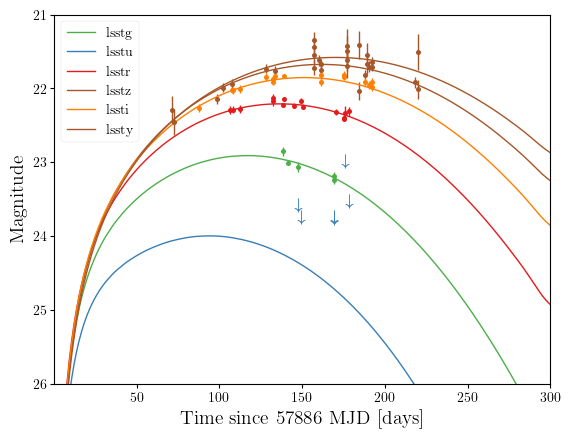

In [34]:
# Make a dictionary for colors on the plot
band_colors = {'lsstg':'#4daf4a', 'lsstu':'#377eb8', 'lsstr':'#e41a1c', 
               'lsstz':'#a65628', 'lssti':'#ff7f00', 'lssty':'#a65628'}
upper_limits = sn_sim.observations[sn_sim.observations['detected'] != 1.0]
data = sn_sim.observations[sn_sim.observations['detected'] == 1.0]
for band in band_colors.keys():
    up = upper_limits[upper_limits['band'] == band]
    dd = data[data['band'] == band]
    plt.errorbar(dd['time (days)'], dd['magnitude'], dd['e_magnitude'], 
                 fmt='x', marker='o', color=band_colors[band])
    plt.scatter(up['time (days)'], up['limiting_magnitude'], s=100, 
                marker=r'$\downarrow$', color=band_colors[band])

    
# We can also plot the true data 
tt = np.linspace(0.1, 300, 200)
# specify output_format 
parameters['output_format'] = 'magnitude'
for band in band_colors.keys():
    parameters['bands'] = band
    out = redback.transient_models.supernova_models.arnett(tt, **parameters)
    plt.plot(tt, out, color=band_colors[band], alpha=1, label=band)

plt.legend()
plt.xlim(0.1, 300)
plt.ylim(26, 21)
plt.xlabel('Time since 57886 MJD [days]', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
# plt.xlabel('Time since explosion (days)')